In [1]:
import torch
import random
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Preprocessing Functions

In [2]:
def get_random_batch(encoded, batch_size, sequence_length):
    # start_idx ~ end_idx 는 batch를 완전하게 구성할 수 있는 범위로 골라진다.
    start_idx = random.randint(0, len(encoded) - batch_size * sequence_length - 1)
    end_idx = start_idx + batch_size * sequence_length + 1
    text_tensor = encoded[start_idx:end_idx]
    text_tensor = torch.tensor(text_tensor)
    # Shape of input, target: (N=batch_size, L=sequence_length)
    text_input = torch.zeros((batch_size, sequence_length))
    text_target = torch.zeros((batch_size, sequence_length))

    for i in range(batch_size):
        text_input[i, :] = (text_tensor[i*sequence_length:(i+1)*sequence_length])
        text_target[i, :] = (text_tensor[i*sequence_length+1:(i+1)*sequence_length+1])

    return text_input.long(), text_target.long()

def get_batch_SGD(encoded, batch_size, sequence_length, shuffle):
    full_length = len(encoded)
    batch_length = batch_size * sequence_length
    batch_per_epoch = full_length // (batch_length)
    
    encoded = encoded[0:batch_length * batch_per_epoch + 1]
    encoded = np.array(encoded)
    
    input = np.zeros((batch_per_epoch, batch_length))
    target = np.zeros((batch_per_epoch, batch_length))
    
    for i in range(batch_per_epoch):
        input[i, :] = encoded[i*batch_length:(i+1)*batch_length]
        target[i, :] = encoded[i*batch_length+1:(i+1)*batch_length+1]
        
    input = input.reshape((batch_per_epoch, batch_size, sequence_length))
    target = target.reshape((batch_per_epoch, batch_size, sequence_length))
    
    if shuffle==True:
        randperm_mini_batch = np.random.permutation(batch_per_epoch)
        input = input.take(randperm_mini_batch, axis=0)
        target = target.take(randperm_mini_batch, axis=0)
        
    for idx in range(input.shape[0]):
        yield input[idx], target[idx]
    #return input, target

# LSTM Model

In [3]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embed = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        # input x: (N, L)
        out = self.embed(x)
        # after embedding: (N, L, vocab_size)
        out, (hidden, cell) = self.lstm(out, (hidden, cell))
        # after LSTM: (N, L, output_size)
        out = self.fc(out)
        # after FC: (N, L, vocab_size)
        return out, (hidden, cell)
    
    def init_state(self, batch_size):
        hidden = torch.zeros((self.num_layers, batch_size, self.hidden_size), requires_grad = True).to(device)
        cell = torch.zeros((self.num_layers, batch_size, self.hidden_size), requires_grad = True).to(device)
        return hidden, cell

# Preparing the Data

In [4]:
with open('data/shakespear.txt', 'r') as f:
    text = f.read()
    
chars = tuple(set(text))
vocab_size = len(chars)
int2char = dict(enumerate(chars))
char2int = {ch: idx for idx, ch in int2char.items()}
encoded = [char2int[ch] for ch in text] 
#encoded = torch.tensor([char2int[ch] for ch in text]).to(device)

In [5]:
batches = get_batch_SGD(encoded, 10, 50, False)
x, y = next(iter(batches))

print(x.shape, y.shape)

(10, 50) (10, 50)


# Defining Hyperparameters

In [28]:
import torch.optim as optim

# LSTM Parameters
hidden_dim = 512
num_layers = 3
dropout = 0.5
batch_size = 2
sequence_length = 50

learning_rate = [1e-4]

epochs = 200
print_every = 45

# Training 1

In [12]:
# import torch.nn.functional as F
# model = LSTM(vocab_size, hidden_dim, num_layers, dropout, vocab_size).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)

# model.train()

# loss_list = []

# for epoch in range(1, epochs + 1):
#     input, target = get_random_batch(encoded, batch_size, sequence_length)
#     hidden, cell = model.init_state(batch_size)
    
#     optimizer.zero_grad()
#     loss = 0
    
#     input = input.to(device)
#     target = target.to(device)
#     target = F.one_hot(target, vocab_size).float()
    
#     pred, (hidden, cell) = model(input, hidden, cell)
#     loss = criterion(pred, target)

#     loss.backward()
#     optimizer.step()
        
#     if epoch % print_every == 0:
#         loss_list.append(loss.item())
#         print(f'Train Epoch: {epoch}/{epochs} \tLoss: {loss.item():.2f}')

# Training 2

In [13]:
import torch.nn.functional as F
from tqdm.auto import tqdm
from tqdm.auto import trange

for lr in learning_rate:
    print(f"learning rate: {lr}")
    model = LSTM(vocab_size, hidden_dim, num_layers, dropout, vocab_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-4)
    model.train()
    loss_list = []
    
    # epoch
    for epoch in trange(1, epochs + 1):  
        batches = get_batch_SGD(encoded, batch_size, sequence_length, shuffle=False)
        with tqdm(batches, unit="batch", leave=False) as tepoch:
        # mini-batch
            for input, target in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                
                input_ = torch.from_numpy(input).long().to(device)
                target_ = torch.from_numpy(target).long().to(device)
                target_ = F.one_hot(target_, vocab_size).float()
                hidden, cell = model.init_state(batch_size)
                
                optimizer.zero_grad()
                pred, (hidden, cell)= model(input_, hidden, cell)
                loss = criterion(pred, target_)

                loss.backward()
                optimizer.step()
                
                tepoch.set_postfix(loss=loss.item())
                
            loss_list.append(loss.item())
            


learning rate: 0.0001


100%|██████████| 50/50 [22:50<00:00, 27.41s/it]


In [29]:
model.train()
for epoch in trange(1, epochs + 1):  
    batches = get_batch_SGD(encoded, batch_size, sequence_length, shuffle=False)
    with tqdm(batches, unit="batch", leave=False) as tepoch:
    # mini-batch
        for input, target in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            
            input_ = torch.from_numpy(input).long().to(device)
            target_ = torch.from_numpy(target).long().to(device)
            target_ = F.one_hot(target_, vocab_size).float()
            hidden, cell = model.init_state(batch_size)
            
            optimizer.zero_grad()
            pred, (hidden, cell)= model(input_, hidden, cell)
            loss = criterion(pred, target_)

            loss.backward()
            optimizer.step()
            
            tepoch.set_postfix(loss=loss.item())
            
        loss_list.append(loss.item())

100%|██████████| 200/200 [1:28:40<00:00, 26.60s/it]


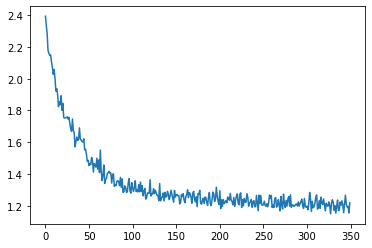

In [30]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_list)

# Text Generating

In [31]:
def generate(initial_str="A", predict_len=10000, sequence_length=1):
    model.eval()
    hidden, cell = model.init_state(1)
    
    initial_tensor = torch.zeros((1,sequence_length)).long()
    initial_tensor[0][0] = char2int[initial_str]

    predicted = initial_str

    last_char = initial_tensor

    for p in range(predict_len):
        output, (hidden, cell) = model(last_char.to(device), hidden, cell)
        topi = torch.argmax(output, dim=2)
        predicted_char = int2char[topi.item()]
        predicted += predicted_char
        
        last_char = torch.zeros((1, sequence_length)).long()
        last_char[0][0] = char2int[predicted_char]
        
    return predicted

generated_text = generate()

In [32]:
print(generated_text)

ARDOS:
Hil, we falthe morgy backy good subton what the comband me.
Herean stay'd, I wist though able?

SIM BENCOLHUS:
Have dong'd forty, spult come?

SIMALUCE:
Baty with the reso, bug Iflence now agas, I'll prowed condimn?

SACELDOUS:
How nates, I't cost prewerty from.

SAcIUM:
But I women'd glody, brays, and felst go'd?

SOcALBUS:
I was mater, by your hearth flibther; giltich we.

BOSATIO:
He's do go, bacted pince, without growent frombter.

SIRACOLIO:
Say, I'll stacced forntung without brother, gals; by sach, for the glow.

BASTILO:
Hast'd notccist?

SHAOCO:
BAting If'll dony, I wromget, proposed, your gructed; backw
Sif we caster but not liftle?

SALDOCHETHI:
Any I loy styef's bad, as I was might.

ScAMUCHO:
And then by grof's, frought ablond.

SIMALON:
Thou wast'r's mutce, Ifreety groved commabbe; as I will.

HONCASSI:
Hot though'ds from, but net?

MARION:
Say's I cangland, bfict; where grot for as I'll dight.

BOSTALUS:
Hath not confus'd, by swear, I smake welcond.

BASTIOL:
Hot t